# Forecasting (CocaCola_Sales)

### Forecast the CocaCola prices data set. Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.


# 1. Import Libs

In [223]:
import pandas as pd
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from datetime import datetime,time
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib
from pandas import DataFrame
from pandas import Grouper
from numpy import log
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
import itertools
import warnings
warnings.filterwarnings('ignore')

# 2. Import Data 

In [224]:
df = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
df

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


# 3. EDA

In [225]:
df.isna().sum()

Quarter    0
Sales      0
dtype: int64

In [226]:
df.dtypes

Quarter     object
Sales      float64
dtype: object

In [227]:
df.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


#### convert quarterly periods to datetime 

In [228]:
df['Quarter_Year'] = df['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))

In [229]:
df

,Quarter,Sales,Quarter_Year
0,Q1_86,1734.827000,Q1 1986
1,Q2_86,2244.960999,Q2 1986
2,Q3_86,2533.804993,Q3 1986
3,Q4_86,2154.962997,Q4 1986
4,Q1_87,1547.818996,Q1 1987
5,Q2_87,2104.411995,Q2 1987
6,Q3_87,2014.362999,Q3 1987
7,Q4_87,1991.746998,Q4 1987
8,Q1_88,1869.049999,Q1 1988
9,Q2_88,2313.631996,Q2 1988


#### converting into datetime formate as the index was not in correct formate.

In [230]:
df['date'] = (pd.to_datetime(df['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1])),dayfirst=True))

In [231]:
df

,Quarter,Sales,Quarter_Year,date
0,Q1_86,1734.827000,Q1 1986,1986-01-01
1,Q2_86,2244.960999,Q2 1986,1986-04-01
2,Q3_86,2533.804993,Q3 1986,1986-07-01
3,Q4_86,2154.962997,Q4 1986,1986-10-01
4,Q1_87,1547.818996,Q1 1987,1987-01-01
5,Q2_87,2104.411995,Q2 1987,1987-04-01
6,Q3_87,2014.362999,Q3 1987,1987-07-01
7,Q4_87,1991.746998,Q4 1987,1987-10-01
8,Q1_88,1869.049999,Q1 1988,1988-01-01
9,Q2_88,2313.631996,Q2 1988,1988-04-01


In [232]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Quarter       42 non-null     object        
 1   Sales         42 non-null     float64       
 2   Quarter_Year  42 non-null     object        
 3   date          42 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.4+ KB


#### droping the Column Quarter and Quarter_Year from the data 


In [233]:
df.drop(columns=['Quarter','Quarter_Year'],inplace=True)

In [234]:
df

,Sales,date
0,1734.827000,1986-01-01
1,2244.960999,1986-04-01
2,2533.804993,1986-07-01
3,2154.962997,1986-10-01
4,1547.818996,1987-01-01
5,2104.411995,1987-04-01
6,2014.362999,1987-07-01
7,1991.746998,1987-10-01
8,1869.049999,1988-01-01
9,2313.631996,1988-04-01


In [235]:
df.isnull().sum()

Sales    0
date     0
dtype: int64

In [236]:
df[df.duplicated()].shape

(0, 2)

In [237]:
Df = df[['date','Sales']]

In [238]:
Df.head()

,date,Sales
0,1986-01-01,1734.827000
1,1986-04-01,2244.960999
2,1986-07-01,2533.804993
3,1986-10-01,2154.962997
4,1987-01-01,1547.818996


In [239]:
Df.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


#### converte date column to index

In [240]:
Df.set_index('date',inplace=True)

In [241]:
Df.head()

,Sales
date,
1986-01-01,1734.827000
1986-04-01,2244.960999
1986-07-01,2533.804993
1986-10-01,2154.962997
1987-01-01,1547.818996


In [242]:
Df.index.year

Int64Index([1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988,
            1988, 1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991,
            1991, 1991, 1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994,
            1994, 1994, 1994, 1995, 1995, 1995, 1995, 1996, 1996],
           dtype='int64', name='date')

In [243]:
DF = Df.copy()

In [244]:
DF.head()

,Sales
date,
1986-01-01,1734.827000
1986-04-01,2244.960999
1986-07-01,2533.804993
1986-10-01,2154.962997
1987-01-01,1547.818996


# 4.Visulization

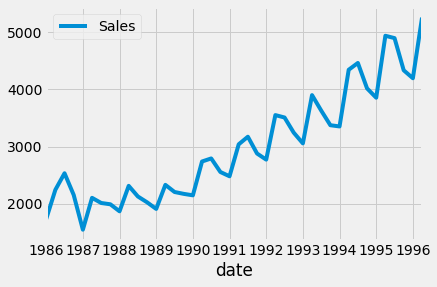

In [245]:
DF.plot()
plt.show()

#### here we can say that the trend is upward and the sessionality is not so clear but may be quadratic or exponential,

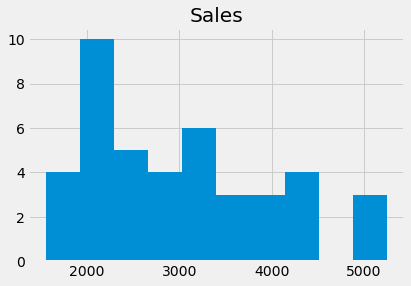

In [246]:
DF.hist()
plt.show()

#### density plot

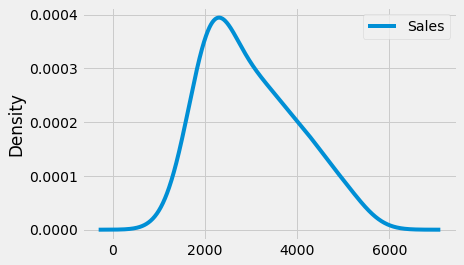

In [247]:

DF.plot(kind='kde')
plt.show()

#### Lag_plot

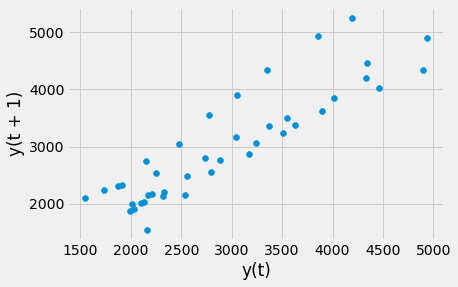

In [249]:
lag_plot(DF)
plt.show()

#### Autocorrelation Plot

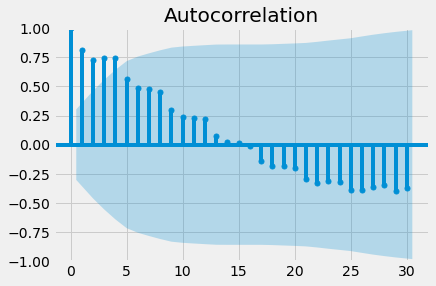

In [250]:
plot_acf(DF,lags=30)
plt.show()

### UpSampling

In [251]:
upsampled = DF.resample('M').mean()
print(upsampled.head(32))

                  Sales
date                   
1986-01-31  1734.827000
1986-02-28          NaN
1986-03-31          NaN
1986-04-30  2244.960999
1986-05-31          NaN
1986-06-30          NaN
1986-07-31  2533.804993
1986-08-31          NaN
1986-09-30          NaN
1986-10-31  2154.962997
1986-11-30          NaN
1986-12-31          NaN
1987-01-31  1547.818996
1987-02-28          NaN
1987-03-31          NaN
1987-04-30  2104.411995
1987-05-31          NaN
1987-06-30          NaN
1987-07-31  2014.362999
1987-08-31          NaN
1987-09-30          NaN
1987-10-31  1991.746998
1987-11-30          NaN
1987-12-31          NaN
1988-01-31  1869.049999
1988-02-29          NaN
1988-03-31          NaN
1988-04-30  2313.631996
1988-05-31          NaN
1988-06-30          NaN
1988-07-31  2128.320000
1988-08-31          NaN


#### interplation is done for nan values

                  Sales
date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330
1986-06-30  2437.523661
1986-07-31  2533.804993
1986-08-31  2407.524328
1986-09-30  2281.243663
1986-10-31  2154.962997
1986-11-30  1952.581664
1986-12-31  1750.200330
1987-01-31  1547.818996
1987-02-28  1733.349996
1987-03-31  1918.880995


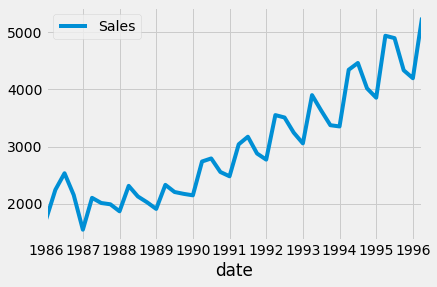

In [252]:
interpolated = upsampled.interpolate(method='linear') 
print(interpolated.head(15))
interpolated.plot()
plt.show()

In [253]:
interpolated

,Sales
date,
1986-01-31,1734.827000
1986-02-28,1904.871666
1986-03-31,2074.916332
1986-04-30,2244.960999
1986-05-31,2341.242330
...,...
1995-12-31,4240.333333
1996-01-31,4194.000000
1996-02-29,4547.000000


# 5. Tranformations

## Square Root Transformation

In [254]:
dataframe = DataFrame(DF.values)
dataframe.columns = ['Sales']
dataframe['Sales'] = sqrt(dataframe['Sales'])

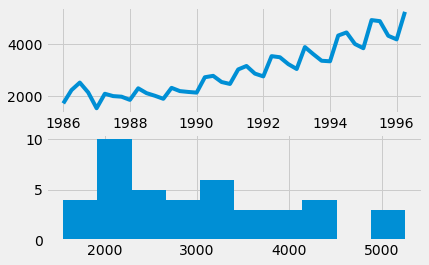

In [255]:
plt.subplot(211)
plt.plot(DF['Sales'])

plt.subplot(212)
plt.hist(DF['Sales'])
plt.show()

## Log Transformation

In [256]:
dataframe = DataFrame(DF.values)
dataframe.columns = ['Sales']
dataframe['Sales'] = log(dataframe['Sales'])

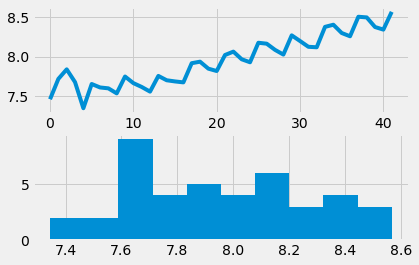

In [257]:
plt.subplot(211)
plt.plot(dataframe['Sales'])

plt.subplot(212)
plt.hist(dataframe['Sales'])
plt.show()

# Moving Average

In [258]:
Train = interpolated.head(112)
Test = interpolated.tail(12)

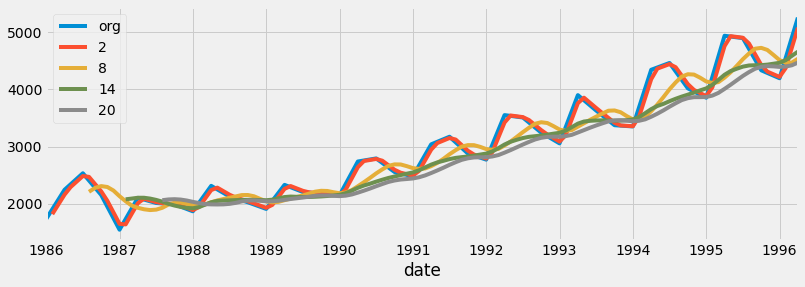

In [259]:
plt.figure(figsize=(12,4))
interpolated.Sales.plot(label="org")
for i in range(2,24,6):
    interpolated["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

## Time series decomposition plot

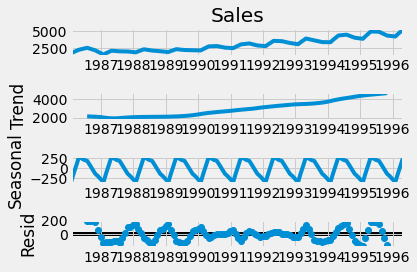

In [260]:
decompose_ts_add = seasonal_decompose(interpolated.Sales,period=12)  
decompose_ts_add.plot()
plt.show()

## ACF plots and PACF plots

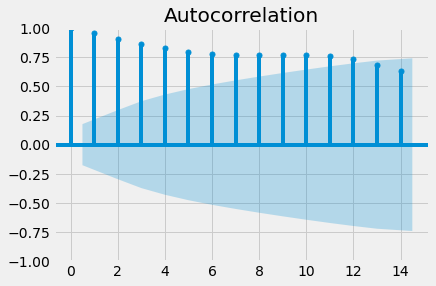

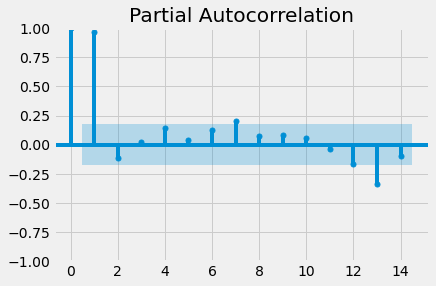

In [261]:
tsa_plots.plot_acf(interpolated.Sales,lags=14)
tsa_plots.plot_pacf(interpolated.Sales,lags=14)
plt.show()

## Evaluation Metric MAPE

In [262]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

## Simple Exponential Method

In [263]:
ses_model = SimpleExpSmoothing(Train["Sales"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Sales)

7.528920151221705

## Holt method

In [264]:
hw_model = Holt(Train["Sales"]).fit(smoothing_level=0.1, smoothing_trend=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Sales)

7.9715447532695825

### Holts winter exponential smoothing with additive seasonality and additive trend

In [265]:
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_trend=0.2)
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Sales)

4.980642076778319

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [266]:
hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_trend=0.2) 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Sales)

4.760059857710733

In [267]:
rmse_hwe_mul_add = sqrt(mean_squared_error(pred_hwe_mul_add,Test.Sales))
rmse_hwe_mul_add

249.77163694491563

# Final Model by combining train and test

In [268]:
hwe_model_add_add = ExponentialSmoothing(interpolated["Sales"],seasonal="add",trend="add",seasonal_periods=10).fit()

### Forecasting for next 10 time periods

In [269]:
hwe_model_add_add.forecast(10)

1996-05-31    5645.853877
1996-06-30    6044.108417
1996-07-31    6424.580532
1996-08-31    6796.899936
1996-09-30    7100.361465
1996-10-31    7422.984410
1996-11-30    7677.114691
1996-12-31    8025.662468
1997-01-31    8323.526408
1997-02-28    8690.513977
Freq: M, dtype: float64

In [270]:
interpolated

,Sales
date,
1986-01-31,1734.827000
1986-02-28,1904.871666
1986-03-31,2074.916332
1986-04-30,2244.960999
1986-05-31,2341.242330
...,...
1995-12-31,4240.333333
1996-01-31,4194.000000
1996-02-29,4547.000000


In [271]:
interpolated.reset_index(inplace=True)

In [272]:
interpolated['t'] = 1

In [273]:
interpolated

,date,Sales,t
0,1986-01-31,1734.827000,1
1,1986-02-28,1904.871666,1
2,1986-03-31,2074.916332,1
3,1986-04-30,2244.960999,1
4,1986-05-31,2341.242330,1
...,...,...,...
119,1995-12-31,4240.333333,1
120,1996-01-31,4194.000000,1
121,1996-02-29,4547.000000,1
122,1996-03-31,4900.000000,1


In [274]:
for i,row in interpolated.iterrows():
  interpolated['t'].iloc[i] = i+1

In [275]:
interpolated

,date,Sales,t
0,1986-01-31,1734.827000,1
1,1986-02-28,1904.871666,2
2,1986-03-31,2074.916332,3
3,1986-04-30,2244.960999,4
4,1986-05-31,2341.242330,5
...,...,...,...
119,1995-12-31,4240.333333,120
120,1996-01-31,4194.000000,121
121,1996-02-29,4547.000000,122
122,1996-03-31,4900.000000,123


#### inserting t_sq column with values

In [276]:
interpolated['t_sq'] = (interpolated['t'])**2

In [277]:
interpolated

,date,Sales,t,t_sq
0,1986-01-31,1734.827000,1,1
1,1986-02-28,1904.871666,2,4
2,1986-03-31,2074.916332,3,9
3,1986-04-30,2244.960999,4,16
4,1986-05-31,2341.242330,5,25
...,...,...,...,...
119,1995-12-31,4240.333333,120,14400
120,1996-01-31,4194.000000,121,14641
121,1996-02-29,4547.000000,122,14884
122,1996-03-31,4900.000000,123,15129


In [278]:
interpolated["month"] = interpolated.date.dt.strftime("%b") # month extraction
interpolated["year"] = interpolated.date.dt.strftime("%Y") # year extraction

In [279]:
interpolated

,date,Sales,t,t_sq,month,year
0,1986-01-31,1734.827000,1,1,Jan,1986
1,1986-02-28,1904.871666,2,4,Feb,1986
2,1986-03-31,2074.916332,3,9,Mar,1986
3,1986-04-30,2244.960999,4,16,Apr,1986
4,1986-05-31,2341.242330,5,25,May,1986
...,...,...,...,...,...,...
119,1995-12-31,4240.333333,120,14400,Dec,1995
120,1996-01-31,4194.000000,121,14641,Jan,1996
121,1996-02-29,4547.000000,122,14884,Feb,1996
122,1996-03-31,4900.000000,123,15129,Mar,1996


In [280]:
months = pd.get_dummies(interpolated['month'])

In [281]:
months

,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
119,0,0,1,0,0,0,0,0,0,0,0,0
120,0,0,0,0,1,0,0,0,0,0,0,0
121,0,0,0,1,0,0,0,0,0,0,0,0
122,0,0,0,0,0,0,0,1,0,0,0,0


In [282]:
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]

In [283]:
Coka_Cola = pd.concat([interpolated,months],axis=1)

In [284]:
Coka_Cola.head()


,date,Sales,t,t_sq,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0
1,1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0
2,1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0
3,1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0
4,1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0


In [285]:
Coka_Cola['log_sales'] = np.log(Coka_Cola['Sales'])

In [286]:
Coka_Cola

,date,Sales,t,t_sq,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
0,1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0,7.458663
1,1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0,7.552170
2,1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0,7.637676
3,1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0,7.716443
4,1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0,7.758437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,1995-12-31,4240.333333,120,14400,Dec,1995,0,0,0,0,0,0,0,0,0,0,0,1,8.352397
120,1996-01-31,4194.000000,121,14641,Jan,1996,1,0,0,0,0,0,0,0,0,0,0,0,8.341410
121,1996-02-29,4547.000000,122,14884,Feb,1996,0,1,0,0,0,0,0,0,0,0,0,0,8.422223
122,1996-03-31,4900.000000,123,15129,Mar,1996,0,0,1,0,0,0,0,0,0,0,0,0,8.496990


<AxesSubplot:xlabel='month', ylabel='year'>

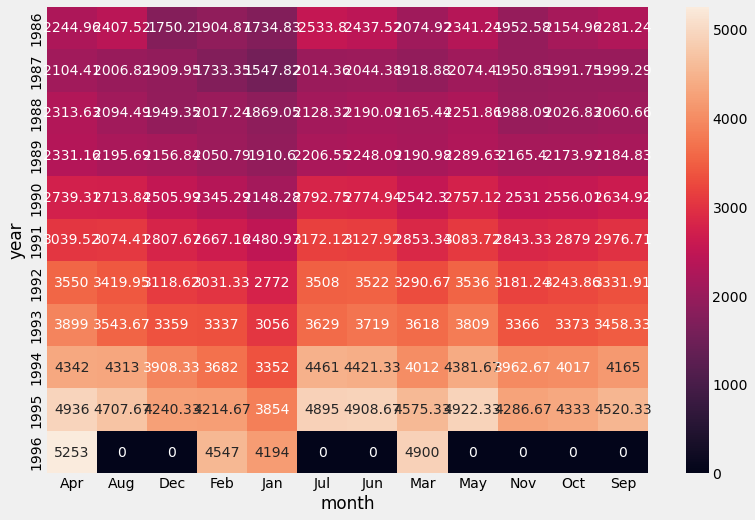

In [287]:
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=Coka_Cola,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

<AxesSubplot:xlabel='year', ylabel='Sales'>

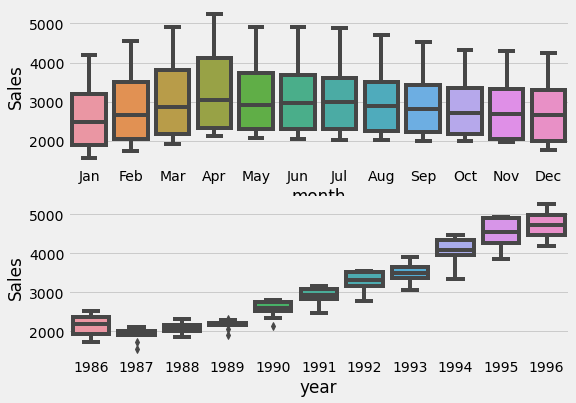

In [288]:
plt.figure(figsize=(8,6))
plt.subplot(211)
sns.boxplot(x="month",y="Sales",data= Coka_Cola)
plt.subplot(212)
sns.boxplot(x="year",y="Sales",data=Coka_Cola)

<AxesSubplot:xlabel='year', ylabel='Sales'>

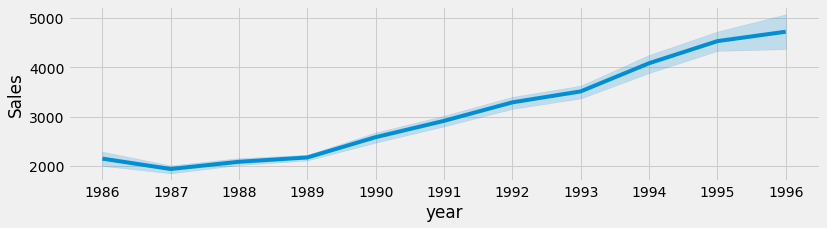

In [289]:
plt.figure(figsize=(12,3))
sns.lineplot(x="year",y="Sales",data=Coka_Cola)

# 6. Comparing Multiple Models

In [290]:
Train = Coka_Cola.head(110) 
Test = Coka_Cola.tail(14) 

## Linear Model

In [291]:
linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2))
rmse_linear

638.120822592281

## Exponential Model

In [292]:
Exp = smf.ols('log_sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

494.4406930545973

## Quadratic Model

In [293]:
Quad = smf.ols('Sales~t+t_sq',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_sq"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

387.28160082928383

## Additive seasonality 

In [294]:
add_sea = smf.ols('Sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1881.813589906022

## Additive Seasonality Quadratic 

In [295]:
add_sea_Quad = smf.ols('Sales~t+t_sq+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_sq']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

242.77660443468957

## Multiplicative Seasonality

In [296]:
Mul_sea = smf.ols('log_sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

1973.2620608123086

## Multiplicative Additive Seasonality 

In [297]:
Mul_Add_sea = smf.ols('log_sales~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea

275.27503211175105

## Compareing the results 

In [298]:
data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
4,rmse_add_sea_quad,242.776604
6,rmse_Mult_add_sea,275.275032
2,rmse_Quad,387.281601
1,rmse_Exp,494.440693
0,rmse_linear,638.120823
3,rmse_add_sea,1881.813590
5,rmse_Mult_sea,1973.262061


# End